
# Hyperspectral Image Classification with 3D CNN

This notebook implements a 3D Convolutional Neural Network (3D CNN) for hyperspectral image classification. The major steps covered are:

- **Loading Preprocessed Data:** Loads normalized hyperspectral image cubes, label maps, and predefined train, validation, and test masks.
- **PyTorch Setup:** Initializes typical PyTorch components such as neural network layers, optimizers, loss functions, device setup, and reproducibility seeds.
- **Dataset Handling:** Uses PyTorch’s `Dataset` and `DataLoader` abstractions to efficiently manage spatial-spectral data for training, validation, and testing.
- **3D CNN Model Definition:** Defines and configures a 3D CNN architecture designed to extract both spatial and spectral features from hyperspectral data.
- **Training and Validation:** Implements training and validation loops with performance tracking, model saving, and early stopping.
- **Performance Metrics:** Evaluates model performance using accuracy, precision, recall, F1-score, Cohen’s kappa, and confusion matrices.
- **Visualization:** Generates and saves plots to interpret training progress and classification results.

Outputs directories for artifacts, figures, and run logs are automatically created to organize results.


In [1]:
from pathlib import Path                                                 # work with file paths
import time                                                              # track run time
import numpy as np                                                       # handle arrays
import matplotlib.pyplot as plt                                          # make plots

import torch                                                             # main deep learning lib
import torch.nn as nn                                                    # layers and losses
import torch.optim as optim                                              # optimizers
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler  # dataset and loaders

from sklearn.metrics import (                                            # classic classification metrics
    confusion_matrix,                                                    # confusion matrix
    accuracy_score,                                                      # accuracy
    precision_recall_fscore_support,                                     # precision recall f1
    cohen_kappa_score,                                                   # kappa
    classification_report,                                               # per class report text
)

np.random.seed(42)                                                       # fix numpy seed for repeat runs
torch.manual_seed(42)                                                    # fix torch seed for repeat runs

ARTIFACTS = Path("outputs/artifacts_ip")                                 # folder with saved arrays from data notebook
FIGS = Path("outputs/figs")                                              # folder for plots
RUNS = Path("outputs/runs_3dcnn")                                        # folder for model files and logs
FIGS.mkdir(parents=True, exist_ok=True)                                  # create figs folder if missing
RUNS.mkdir(parents=True, exist_ok=True)                                  # create runs folder if missing

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")    # choose device
print("Device", DEVICE)                                                  # show device choice

Device cuda


In [2]:
cube = np.load(ARTIFACTS / "cube_clean_norm.npy")           # load H by W by B cube with z score bands
labels = np.load(ARTIFACTS / "labels.npy")                  # load H by W label map with one based ids and zero for background
mask_train = np.load(ARTIFACTS / "mask_train.npy")          # load H by W boolean mask for train pixels
mask_val   = np.load(ARTIFACTS / "mask_val.npy")            # load H by W boolean mask for val pixels
mask_test  = np.load(ARTIFACTS / "mask_test.npy")           # load H by W boolean mask for test pixels

H, W, B = cube.shape                                        # get height width and band count
num_classes = int(labels.max())                             # get number of foreground classes
print("Cube", cube.shape, "Classes", num_classes)           # print quick summary

Cube (145, 145, 200) Classes 16


In [3]:
class PatchDataset3D(Dataset):                                                              # define custom dataset for three D patches
    def __init__(self, cube_c_last: np.ndarray, lab_map: np.ndarray, mask_map: np.ndarray,  # init with cube labels and mask
                 patch: int):
        assert patch % 2 == 1, "patch must be odd"                                          # require odd patch size
        self.patch = patch                                                                  # store patch size
        self.rad = patch // 2                                                               # store radius
        self.H, self.W, self.C = cube_c_last.shape                                          # store sizes

        self.img = np.pad(                                                                  # pad spatial dims so borders are valid
            cube_c_last.astype(np.float32),                                                 # convert to float32
            ((self.rad, self.rad), (self.rad, self.rad), (0, 0)),                           # pad height and width only
            mode="reflect"                                                                  # reflect padding
        )

        yy, xx = np.where(mask_map & (lab_map > 0))                                         # find rows and cols for valid pixels
        self.centers = np.stack([yy, xx], axis=1)                                           # stack centers as N by two
        self.labels = lab_map[mask_map & (lab_map > 0)].astype(np.int64) - 1                # store zero based class ids

    def __len__(self):                                                                       
        return self.centers.shape[0]                                                        # number of samples

    def __getitem__(self, i):                                                               # get one sample
        y, x = self.centers[i]                                                              # read center row and col
        yp, xp = y + self.rad, x + self.rad                                                 # shift into padded image
        patch_hw_c = self.img[yp - self.rad: yp + self.rad + 1,                             # slice P by P by C window
                               xp - self.rad: xp + self.rad + 1, :]
        patch_c_hw = np.transpose(patch_hw_c, (2, 0, 1))                                    # change to C by P by P

        patch_1_c_hw = np.expand_dims(patch_c_hw, axis=0)                                   # make it one by C by P by P for three D conv
        x_t = torch.from_numpy(patch_1_c_hw)                                                # convert to tensor with shape one by C by P by P
        y_t = torch.tensor(self.labels[i], dtype=torch.long)                                # label tensor
        return x_t, y_t                                                                     # return pair

PATCH = 15                                                                                  # choose default patch size

ds_train = PatchDataset3D(cube, labels, mask_train, patch=PATCH)                            # build train dataset
ds_val   = PatchDataset3D(cube, labels, mask_val,   patch=PATCH)                            # build val dataset
ds_test  = PatchDataset3D(cube, labels, mask_test,  patch=PATCH)                            # build test dataset

print("Train", len(ds_train), "Val", len(ds_val), "Test", len(ds_test), "Bands", B)         # show dataset sizes

Train 7686 Val 513 Test 2050 Bands 200


In [4]:
BATCH = 32                                                                                          # smaller batch since three D is heavy

y_tr = ds_train.labels                                                                              # read train labels
counts = np.bincount(y_tr, minlength=num_classes).astype(np.float32)                                # count per class
class_w = 1.0 / np.maximum(counts, 1.0)                                                             # inverse frequency per class
sample_w = class_w[y_tr]                                                                            # weight per sample

sampler = WeightedRandomSampler(                                                                    # make weighted sampler
    weights=torch.from_numpy(sample_w),                                                             # pass weights
    num_samples=len(sample_w),                                                                      # draw this many each epoch
    replacement=True,                                                                               # sample with replacement
)

dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, drop_last=False, num_workers=0)  # train loader
dl_val   = DataLoader(ds_val,   batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)    # val loader
dl_test  = DataLoader(ds_test,  batch_size=BATCH, shuffle=False, drop_last=False, num_workers=0)    # test loader

print("Batches  train", len(dl_train), "val", len(dl_val), "test", len(dl_test))                    # print loader sizes

Batches  train 241 val 17 test 65


In [5]:
class CNN3D(nn.Module):                                                               # define three D CNN
    def __init__(self, in_ch: int, num_classes: int):                                 # init with input channels and classes
        super().__init__()                                                            # parent init

                                                                                      # we treat spectral as depth and use in channel equal to one
                                                                                      # kernel is kD by kH by kW where kD works along bands
        self.feat = nn.Sequential(                                                    # feature extractor
            nn.Conv3d(1, 16, kernel_size=(7, 3, 3), padding=(3, 1, 1), bias=False),   # first three D conv
            nn.BatchNorm3d(16),                                                       # norm
            nn.ReLU(inplace=True),                                                    # relu

            nn.Conv3d(16, 16, kernel_size=(5, 3, 3), padding=(2, 1, 1), bias=False),  # second three D conv
            nn.BatchNorm3d(16),                                                       # norm
            nn.ReLU(inplace=True),                                                    # relu
            nn.MaxPool3d(kernel_size=(1, 2, 2)),                                      # pool spatial only

            nn.Conv3d(16, 32, kernel_size=(5, 3, 3), padding=(2, 1, 1), bias=False),  # third three D conv
            nn.BatchNorm3d(32),                                                       # norm
            nn.ReLU(inplace=True),                                                    # relu

            nn.Conv3d(32, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1), bias=False),  # fourth three D conv
            nn.BatchNorm3d(32),                                                       # norm
            nn.ReLU(inplace=True),                                                    # relu
            nn.MaxPool3d(kernel_size=(1, 2, 2)),                                      # pool spatial only

            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1), bias=False),  # fifth three D conv
            nn.BatchNorm3d(64),                                                       # norm
            nn.ReLU(inplace=True),                                                    # relu
        )

        self.pool_sp = nn.AdaptiveAvgPool3d((None, 1, 1))                             # pool to keep depth and make one by one spatial
        self.pool_d  = nn.AdaptiveAvgPool3d((1, 1, 1))                                # pool to collapse depth for head

        self.head = nn.Sequential(                                                    # classifier head
            nn.Flatten(),                                                             # flatten to vector
            nn.Linear(64, 256),                                                       # hidden layer
            nn.ReLU(inplace=True),                                                    # relu
            nn.Linear(256, num_classes),                                              # logits for classes
        )

    def forward(self, x):                                                             # forward pass
        z = self.feat(x)                                                              # run feature stack
        z = self.pool_sp(z)                                                           # pool spatial dims
        z = self.pool_d(z)                                                            # pool depth to one
        out = self.head(z)                                                            # run head
        return out                                                                    # return logits

model = CNN3D(in_ch=1, num_classes=num_classes).to(DEVICE)                            # create model on device
print("Params", sum(p.numel() for p in model.parameters()))                           # show parameter count

Params 139584


In [6]:
criterion = nn.CrossEntropyLoss()                                                      # set loss to cross entropy
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-5)                # set AdamW optimizer
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=40)                  # set cosine schedule

def metrics_from_logits(logits: torch.Tensor, targets: torch.Tensor, C: int) -> dict:  # helper to compute metrics
    preds = logits.argmax(1).cpu().numpy()                                             # get predicted ids
    true = targets.cpu().numpy()                                                       # get true ids
    acc = accuracy_score(true, preds)                                                  # compute accuracy
    prec, rec, f1, _ = precision_recall_fscore_support(true, preds,                    # compute macro precision recall f1
                                                       labels=np.arange(C),
                                                       average="macro",
                                                       zero_division=0)
    kap = cohen_kappa_score(true, preds)                                               # compute kappa
    cm = confusion_matrix(true, preds, labels=np.arange(C))                            # compute confusion matrix
    return {"acc": acc, "prec": prec, "rec": rec, "f1": f1, "kappa": kap, "cm": cm}    # pack results

In [7]:
EPOCHS = 100                                                                                             # set max epochs
PATIENCE = 12                                                                                            # set early stop patience
best_score = float("-inf")                                                                               # best macro f1 so far
best_state = None                                                                                        # best weights holder
best_epoch = 0                                                                                           # epoch of best model
bad_epochs = 0                                                                                           # count epochs with no gain
history = []                                                                                             # list to store logs

t0 = time.time()                                                                                         # start timer

for ep in range(1, EPOCHS + 1):                                                                          # loop over epochs
    model.train()                                                                                        # set train mode
    run, n = 0.0, 0                                                                                      # reset sums
    for xb, yb in dl_train:                                                                              # loop over train batches
        xb = xb.to(DEVICE)                                                                               # move data to device
        yb = yb.to(DEVICE)                                                                               # move labels to device
        optimizer.zero_grad(set_to_none=True)                                                            # clear grads
        lg = model(xb)                                                                                   # forward pass
        ls = criterion(lg, yb)                                                                           # compute loss
        ls.backward()                                                                                    # backward pass
        optimizer.step()                                                                                 # update weights
        run += ls.item() * xb.size(0)                                                                    # sum loss
        n += xb.size(0)                                                                                  # sum items
    tr_loss = run / max(1, n)                                                                            # compute mean train loss

    model.eval()                                                                                         # set eval mode
    with torch.no_grad():                                                                                # no gradients for eval
        all_lg, all_y = [], []                                                                           # prepare holders
        for xb, yb in dl_val:                                                                            # loop over val batches
            all_lg.append(model(xb.to(DEVICE)))                                                          # collect logits
            all_y.append(yb.to(DEVICE))                                                                  # collect labels
        lg_cat = torch.cat(all_lg, 0)                                                                    # stack logits
        y_cat  = torch.cat(all_y, 0)                                                                     # stack labels
        v_metrics = metrics_from_logits(lg_cat, y_cat, num_classes)                                      # compute metrics
    scheduler.step()                                                                                     # step scheduler

    history.append({"epoch": ep, "train_loss": tr_loss,                                                  # save log row
                    "val_acc": v_metrics["acc"], "val_f1": v_metrics["f1"]})
    print(f"Epoch {ep:03d}  tl {tr_loss:.4f}  va {v_metrics['acc']:.4f}  vf {v_metrics['f1']:.4f}")      # show progress

    if v_metrics["f1"] > best_score:                                                                     # check improvement
        best_score = v_metrics["f1"]                                                                     # update best score
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}                # copy weights to cpu
        best_epoch = ep                                                                                  # store epoch
        bad_epochs = 0                                                                                   # reset patience
    else:
        bad_epochs += 1                                                                                  # count one bad epoch
        if bad_epochs >= PATIENCE:                                                                       # check patience
            print("Early stop at epoch", ep, "best epoch", best_epoch, "best F1", round(best_score, 4))  # stop note
            break                                                                                        # exit loop

train_time = time.time() - t0                                                                            # total time seconds
print("Train time seconds", round(train_time, 2))                                                        # print total time

ckpt_path = RUNS / "cnn3d_fullbands_best.pth"                                                            # set save path
torch.save({"state_dict": best_state, "num_classes": num_classes,                                        # save checkpoint with meta
            "PATCH": PATCH, "B": B}, ckpt_path)                                                          # include patch and band count
print("Saved", ckpt_path.as_posix())                                                                     # confirm save

Epoch 001  tl 1.0419  va 0.5731  vf 0.6939
Epoch 002  tl 0.3691  va 0.7914  vf 0.8630
Epoch 003  tl 0.2281  va 0.8928  vf 0.9405
Epoch 004  tl 0.1433  va 0.8889  vf 0.9216
Epoch 005  tl 0.1440  va 0.9279  vf 0.9254
Epoch 006  tl 0.1129  va 0.9805  vf 0.9878
Epoch 007  tl 0.0744  va 0.9903  vf 0.9948
Epoch 008  tl 0.0504  va 0.8908  vf 0.9358
Epoch 009  tl 0.0488  va 0.9591  vf 0.9737
Epoch 010  tl 0.0505  va 0.9766  vf 0.9870
Epoch 011  tl 0.0358  va 0.9805  vf 0.9903
Epoch 012  tl 0.0329  va 0.9864  vf 0.9930
Epoch 013  tl 0.0290  va 0.9747  vf 0.9832
Epoch 014  tl 0.0191  va 0.9981  vf 0.9991
Epoch 015  tl 0.0435  va 0.9864  vf 0.9859
Epoch 016  tl 0.0311  va 0.9961  vf 0.9984
Epoch 017  tl 0.0065  va 0.9981  vf 0.9991
Epoch 018  tl 0.0098  va 1.0000  vf 1.0000
Epoch 019  tl 0.0122  va 0.9981  vf 0.9991
Epoch 020  tl 0.0043  va 0.9981  vf 0.9991
Epoch 021  tl 0.0078  va 0.9961  vf 0.9955
Epoch 022  tl 0.0094  va 0.9981  vf 0.9991
Epoch 023  tl 0.0034  va 1.0000  vf 1.0000
Epoch 024  

Val accuracy 1.0
Val kappa 1.0
Val f1 macro 1.0


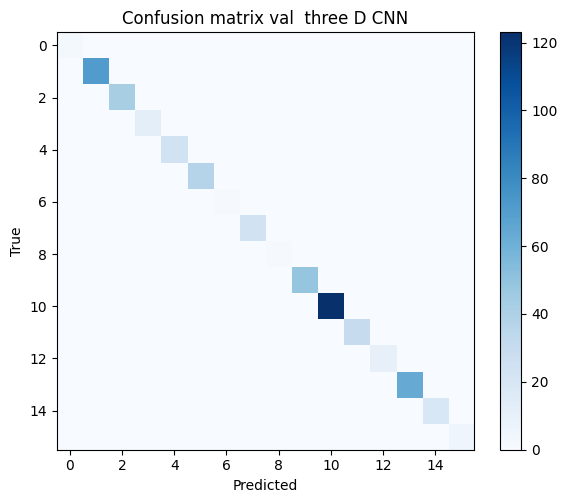

In [8]:
model.load_state_dict(best_state)                               # load best weights
model.to(DEVICE).eval()                                         # set eval mode

with torch.no_grad():                                           # no grads
    v_logits, v_targets = [], []                                # holders
    for xb, yb in dl_val:                                       # loop val
        v_logits.append(model(xb.to(DEVICE)))                   # logits
        v_targets.append(yb.to(DEVICE))                         # labels
    v_logits = torch.cat(v_logits, 0)                           # stack logits
    v_targets = torch.cat(v_targets, 0)                         # stack labels
    vm = metrics_from_logits(v_logits, v_targets, num_classes)  # compute metrics

print("Val accuracy", vm["acc"])                                # print accuracy
print("Val kappa", vm["kappa"])                                 # print kappa
print("Val f1 macro", vm["f1"])                                 # print macro f1

plt.figure(figsize=(6, 5))                                      # new figure
plt.imshow(vm["cm"], cmap="Blues")                              # plot confusion
plt.title("Confusion matrix val  three D CNN")                  # set title
plt.xlabel("Predicted")                                         # x label
plt.ylabel("True")                                              # y label
plt.colorbar()                                                  # draw color bar
plt.tight_layout()                                              # tidy layout
plt.savefig(FIGS / "cnn3d_confusion_val.png", dpi=150)          # save figure
plt.show()                                                      # show figure

Test accuracy 0.9960975609756098
Test kappa 0.9955492110705233
Test f1 macro 0.9946391954440805


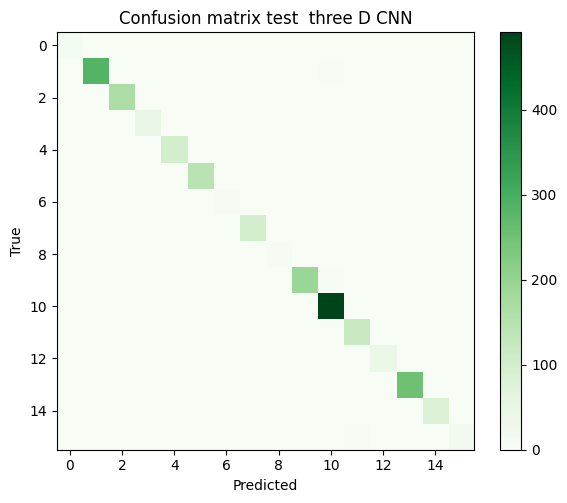


Classification report on test
              precision    recall  f1-score   support

     class_1     1.0000    1.0000    1.0000         9
     class_2     1.0000    0.9895    0.9947       286
     class_3     1.0000    1.0000    1.0000       166
     class_4     1.0000    1.0000    1.0000        47
     class_5     1.0000    1.0000    1.0000        97
     class_6     1.0000    0.9932    0.9966       146
     class_7     1.0000    1.0000    1.0000         5
     class_8     1.0000    1.0000    1.0000        96
     class_9     1.0000    1.0000    1.0000         4
    class_10     1.0000    0.9897    0.9948       194
    class_11     0.9919    1.0000    0.9959       491
    class_12     0.9835    1.0000    0.9917       119
    class_13     1.0000    1.0000    1.0000        41
    class_14     0.9922    1.0000    0.9961       253
    class_15     1.0000    1.0000    1.0000        77
    class_16     1.0000    0.8947    0.9444        19

    accuracy                         0.9961      

In [9]:
with torch.no_grad():                                                        # no grads
    t_logits, t_targets = [], []                                             # holders
    for xb, yb in dl_test:                                                   # loop test
        t_logits.append(model(xb.to(DEVICE)))                                # logits
        t_targets.append(yb.to(DEVICE))                                      # labels
    t_logits = torch.cat(t_logits, 0)                                        # stack logits
    t_targets = torch.cat(t_targets, 0)                                      # stack labels
    tm = metrics_from_logits(t_logits, t_targets, num_classes)               # compute metrics

print("Test accuracy", tm["acc"])                                            # print accuracy
print("Test kappa", tm["kappa"])                                             # print kappa
print("Test f1 macro", tm["f1"])                                             # print macro f1

plt.figure(figsize=(6, 5))                                                   # new figure
plt.imshow(tm["cm"], cmap="Greens")                                          # plot confusion
plt.title("Confusion matrix test  three D CNN")                              # set title
plt.xlabel("Predicted")                                                      # x label
plt.ylabel("True")                                                           # y label
plt.colorbar()                                                               # draw color bar
plt.tight_layout()                                                           # tidy layout
plt.savefig(FIGS / "cnn3d_confusion_test.png", dpi=150)                      # save figure
plt.show()                                                                   # show figure

names = [f"class_{i}" for i in range(1, num_classes + 1)]                    # build class names
print("\nClassification report on test")                                     # header line
print(classification_report(t_targets.cpu().numpy(),                         # print full report
                            t_logits.argmax(1).cpu().numpy(),
                            target_names=names, digits=4, zero_division=0))


In [10]:
from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
)

                                                                                   # convert tensors to numpy
y_true = t_targets.cpu().numpy()
y_pred = t_logits.argmax(1).cpu().numpy()

                                                                                   # global metrics
oa = accuracy_score(y_true, y_pred)
kappa = cohen_kappa_score(y_true, y_pred)

prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average="macro", zero_division=0
)
prec_weighted, rec_weighted, f1_weighted, _ = precision_recall_fscore_support(
    y_true, y_pred, average="weighted", zero_division=0
)

                                                                                   # per class metrics
prec_class, rec_class, f1_class, support_class = precision_recall_fscore_support(
    y_true, y_pred, average=None, zero_division=0
)

print("Overall accuracy:", oa)
print("Cohen kappa:", kappa)
print("Macro precision:", prec_macro)
print("Macro recall:", rec_macro)
print("Macro f1:", f1_macro)
print("Weighted precision:", prec_weighted)
print("Weighted recall:", rec_weighted)
print("Weighted f1:", f1_weighted)

print("\nPer class metrics")
for i, (p, r, f1, s) in enumerate(
    zip(prec_class, rec_class, f1_class, support_class), start=1
):
    print(
        f"Class {i:02d}: "
        f"precision={p:.4f}, recall={r:.4f}, f1={f1:.4f}, support={s}"
    )

print("\nFull classification report")
print(
    classification_report(
        y_true,
        y_pred,
        target_names=[f"class_{i}" for i in range(1, num_classes + 1)],
        digits=4,
        zero_division=0,
    )
)


Overall accuracy: 0.9960975609756098
Cohen kappa: 0.9955492110705233
Macro precision: 0.9979716955652784
Macro recall: 0.9916930461372966
Macro f1: 0.9946391954440805
Weighted precision: 0.9961371060283282
Weighted recall: 0.9960975609756098
Weighted f1: 0.9960731805873696

Per class metrics
Class 01: precision=1.0000, recall=1.0000, f1=1.0000, support=9
Class 02: precision=1.0000, recall=0.9895, f1=0.9947, support=286
Class 03: precision=1.0000, recall=1.0000, f1=1.0000, support=166
Class 04: precision=1.0000, recall=1.0000, f1=1.0000, support=47
Class 05: precision=1.0000, recall=1.0000, f1=1.0000, support=97
Class 06: precision=1.0000, recall=0.9932, f1=0.9966, support=146
Class 07: precision=1.0000, recall=1.0000, f1=1.0000, support=5
Class 08: precision=1.0000, recall=1.0000, f1=1.0000, support=96
Class 09: precision=1.0000, recall=1.0000, f1=1.0000, support=4
Class 10: precision=1.0000, recall=0.9897, f1=0.9948, support=194
Class 11: precision=0.9919, recall=1.0000, f1=0.9959, su

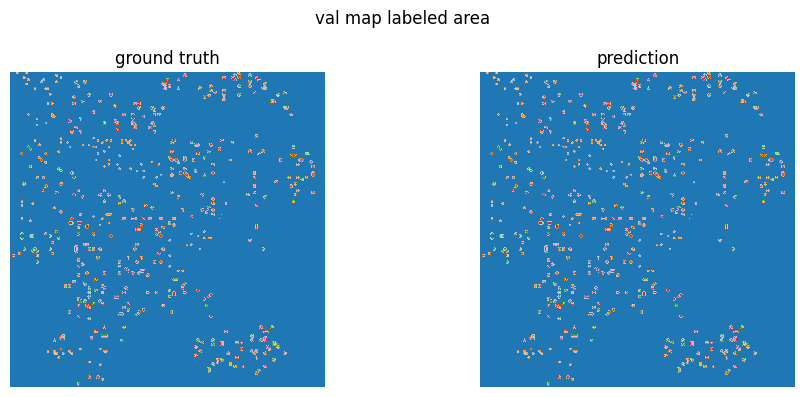

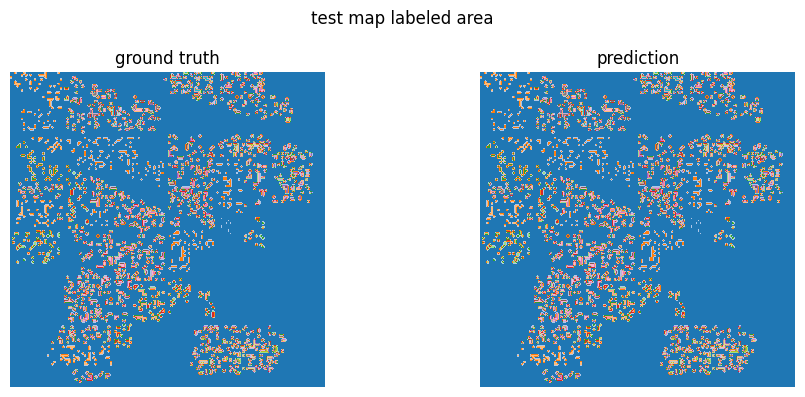

In [11]:
def predict_on_mask_3d(model, ds: PatchDataset3D, mask_map: np.ndarray, num_classes: int) -> np.ndarray:  # function to make maps
    model.eval()                                                                                          # set eval mode
    pred_map = np.zeros_like(labels, dtype=np.int64)                                                      # init map with zeros
    loader = DataLoader(ds, batch_size=128, shuffle=False)                                                # small loader for speed
    idx = 0                                                                                               # running write index
    with torch.no_grad():                                                                                 # no grads
        for xb, _ in loader:                                                                              # loop batches
            lg = model(xb.to(DEVICE))                                                                     # run model
            pb = lg.argmax(1).cpu().numpy() + 1                                                           # back to one based ids
            n = pb.shape[0]                                                                               # count in batch
            for j in range(n):                                                                            # write each center
                y, x = ds.centers[idx + j]                                                                # read center coords
                pred_map[y, x] = pb[j]                                                                    # set prediction
            idx += n                                                                                      # move index
    pred_map[~mask_map] = 0                                                                               # keep zeros off mask
    return pred_map                                                                                       # return map

pred_val_map = predict_on_mask_3d(model, ds_val, mask_val & (labels > 0), num_classes)                    # make val map
pred_test_map = predict_on_mask_3d(model, ds_test, mask_test & (labels > 0), num_classes)                 # make test map

def show_maps(gt, pr, title, fname):                                                                      # helper to show maps
    plt.figure(figsize=(10, 4))                                                                           # make figure
    plt.subplot(1, 2, 1)                                                                                  # left panel
    plt.imshow(gt, cmap="tab20")                                                                          # show ground truth
    plt.title("ground truth")                                                                             # set title
    plt.axis("off")                                                                                       # hide axes
    plt.subplot(1, 2, 2)                                                                                  # right panel
    plt.imshow(pr, cmap="tab20")                                                                          # show prediction
    plt.title("prediction")                                                                               # set title
    plt.axis("off")                                                                                       # hide axes
    plt.suptitle(title)                                                                                   # big title
    plt.tight_layout()                                                                                    # tidy layout
    plt.savefig(FIGS / fname, dpi=150)                                                                    # save figure
    plt.show()                                                                                            # draw figure

show_maps(np.where(mask_val, labels, 0), pred_val_map, "val map labeled area", "cnn3d_val_maps.png")      # show val maps
show_maps(np.where(mask_test, labels, 0), pred_test_map, "test map labeled area", "cnn3d_test_maps.png")  # show test maps